In [1]:
from call_functions import *
import matplotlib.pyplot as plt
import plotly.express as px

## Comparaison between $fA$ and $fA$ mini convergence

In [23]:
# ------------------------------
# Parameters to tune
# ------------------------------

x0 = 0
L = 2 * np.pi
Nx = 2**6 +1
Nf = Nx // 2
dt = 1e-3
a = 1
g = 1
gain = 1
T_start = 0
T = 500
N_ini_fq = 2**3

# ------------------------------
# Space discretization
# ------------------------------

dx = L / Nx
Lx = L - dx
xspan = np.arange(x0, Lx + dx, dx)
frequences = np.fft.fftfreq(Nx, dx) * 2 * np.pi
frequences2 = fftfreq(Nx, dx) * 2 * np.pi # same as above

# ------------------------------
# Time discretization
# ------------------------------

T_end = T_start + T
tspan = np.arange(T_start, T_end + dt, dt)
Nt = len(tspan)

# ------------------------------
# Matrix computations
# ------------------------------

# ------------------------------
# 1) DFT and iDFT Matrices (as well as no mean matrices)
DFT = 1 / Nx * getDFT(Nx)
iDFT = getiDFT(Nx)

# ------------------------------
# 2) True matrix A not in Fourier
O = np.zeros((Nx, Nx))
I = np.eye(Nx)
G = Matrix_A_dz(Nx, dx)
_, C = GetC(np.abs(xspan - np.pi) <= a)
obs_space = np.abs(xspan - np.pi) <= a
C = -np.dot(C.T, C)
A = np.block([[O, -I], [G, C]])

# ------------------------------
# 3) True matrix A in Fourier
fO = np.zeros((2 * Nf + 1, 2 * Nf + 1))
fI = -np.eye(2 * Nf + 1)
fF = np.diag(np.abs(np.concatenate((np.arange(0, Nf + 1), np.arange(-Nf, 0)))))
frequences = fftfreq(Nx, dx) * 2 * np.pi  # Assuming the previously defined fftfreq function
fC = np.real(-((a * np.exp((-1j * np.pi) * (frequences.reshape(-1, 1) - frequences))) / np.pi) * np.sinc(a * (frequences.reshape(-1, 1) - frequences) / np.pi))
fA = np.block([[fO, fI], [fF, fC]])

# Matrix that deletes the mean
Pi_nm = np.diag(np.concatenate((np.zeros(1),np.ones(Nx-1))))

# Modified fA
fA_mod_nm = np.block([[fO, fI], [fF, Pi_nm @ fC]])

# vector with list of all the positive frequencices
pos_frequences = frequences[1:int((len(frequences)-1)/2)+1]

# Matrix that deletes the mean and the high frequencies
Pi_bf = np.diag(np.concatenate((np.zeros(1),(pos_frequences <= N_ini_fq),(pos_frequences <= N_ini_fq)[::-1])))
Pi_hf = np.diag(np.concatenate((np.zeros(1),(pos_frequences > N_ini_fq),(pos_frequences > N_ini_fq)[::-1])))

# second Modified fA
fA_mod_bf = np.block([[fO, fI], [fF, Pi_bf @ fC]])

# ------------------------------
# 4) True matrix A in Fourier (mini)
Nfmini = N_ini_fq
Nxmini = 2*Nfmini + 1
dxmini = L / Nxmini
fOmini = np.zeros((2 * Nfmini + 1, 2 * Nfmini + 1))
fImini = -np.eye(2 * Nfmini + 1)
fFmini = np.diag(np.abs(np.concatenate((np.arange(0, Nfmini + 1), np.arange(-Nfmini, 0)))))
frequencesmini = fftfreq(Nxmini, dxmini) * 2 * np.pi  # Assuming the previously defined fftfreq function
fCmini = np.real(-((a * np.exp((-1j * np.pi) * (frequencesmini.reshape(-1, 1) - frequencesmini))) / np.pi) * np.sinc(a * (frequencesmini.reshape(-1, 1) - frequencesmini) / np.pi))
fAmini = np.block([[fOmini, fImini], [fFmini, fCmini]])

# Matrix that deletes the mean
Pimini_nm = np.diag(np.concatenate((np.zeros(1),np.ones(Nxmini-1))))

# Modified fA
fAmini_mod_nm = np.block([[fOmini, fImini], [fFmini, Pimini_nm @ fCmini]])

# # vector with list of all the positive frequencices
# pos_frequences = frequences[1:int((len(frequences)-1)/2)+1]

# # Matrix that deletes the mean and the high frequencies
# Pi_bf = np.diag(np.concatenate((np.zeros(1),(pos_frequences <= N_ini_fq),(pos_frequences <= N_ini_fq)[::-1])))
# Pi_hf = np.diag(np.concatenate((np.zeros(1),(pos_frequences > N_ini_fq),(pos_frequences > N_ini_fq)[::-1])))

# # second Modified fA
# fA_mod_bf = np.block([[fO, fI], [fF, Pi_bf @ fC]])

In [24]:
np.random.seed(1)
X0_mix = create_Fourier_X0(N_ini_fq,N_ini_fq, Nx, dx)
X0mini_mix = np.zeros(1)
for i,val in enumerate(X0_mix):
    if X0_mix[i] > 1e-12: X0mini_mix = np.concatenate((X0mini_mix,np.array([val])))

In [25]:
# Creating fX0_sin, fX0_cos and fX0_mix

fX0_mix = np.concatenate((X0_mix,X0_mix))
fX0mini_mix = np.concatenate((X0mini_mix,X0mini_mix))

In [26]:
# ------------------------------
# Time integration scheme
# ------------------------------

# def Euler_Explicit(mat, X0, tspan):
#     X = np.zeros((X0.shape[0],tspan.shape[0])) + np.zeros((X0.shape[0],tspan.shape[0]))*1j
#     dt = tspan[1] - tspan[0]
#     X[:,0] = X0
#     for i in range(1,len(tspan)):
#         X[:,i] = X[:,i-1] + dt * mat @ X[:,i-1]
#     return X

In [27]:
# ------------------------------
# Time integration with fX0_mix
# ------------------------------

fX_sol_EE_fA_mix = Euler_Explicit(fA,fX0_mix,tspan)
print('1st edo : done')
fX_sol_EE_fA_mod_nm_mix = Euler_Explicit(fA_mod_nm,fX0_mix,tspan)
print('2nd edo : done')
fX_sol_EE_fA_mod_bf_mix = Euler_Explicit(fA_mod_bf,fX0_mix,tspan)
print('3rd edo : done')

1st edo : done
2nd edo : done
3rd edo : done


In [28]:
# ------------------------------
# Time integration with fX0_mix
# ------------------------------

fX_sol_EE_fAmini_mix = Euler_Explicit(fAmini,fX0mini_mix,tspan)
print('1st edo : done')
fX_sol_EE_fAmini_mod_nm_mix = Euler_Explicit(fAmini_mod_nm,fX0mini_mix,tspan)
print('2nd edo : done')

1st edo : done
2nd edo : done


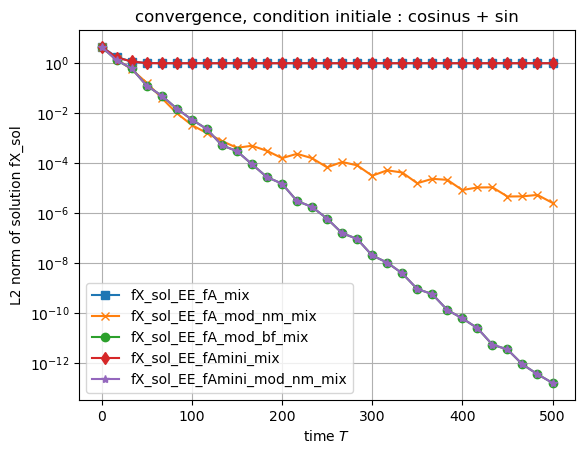

In [29]:
steps = tspan.shape[0]//30
plt.semilogy(tspan[::steps],np.linalg.norm(fX_sol_EE_fA_mix[0:,::steps],2,axis=0),'-s',label='fX_sol_EE_fA_mix')
plt.semilogy(tspan[::steps],np.linalg.norm(fX_sol_EE_fA_mod_nm_mix[0:,::steps],2,axis=0),'-x',label='fX_sol_EE_fA_mod_nm_mix')
plt.semilogy(tspan[::steps],np.linalg.norm(fX_sol_EE_fA_mod_bf_mix[0:,::steps],2,axis=0),'-o',label='fX_sol_EE_fA_mod_bf_mix')
plt.semilogy(tspan[::steps],np.linalg.norm(fX_sol_EE_fAmini_mix[0:,::steps],2,axis=0),'-d',label='fX_sol_EE_fAmini_mix')
plt.semilogy(tspan[::steps],np.linalg.norm(fX_sol_EE_fAmini_mod_nm_mix[0:,::steps],2,axis=0),'-*',label='fX_sol_EE_fAmini_mod_nm_mix')
plt.title(r'convergence, condition initiale : cosinus + sin')
plt.grid()
plt.legend()
plt.xlabel(r'time $T$')
plt.ylabel(r'L2 norm of solution fX_sol')
plt.show()

## Convergence rate $\gamma$

In [30]:
nb_gamma = 50
gamma_list = (10*np.ones(nb_gamma))**np.linspace(-5,3,nb_gamma)

In [31]:
conv_factor_the = np.zeros(nb_gamma)
fX_sol = {}
for i,gamma in enumerate(gamma_list):
    fAmini_i = np.block([[fOmini, fImini], [fFmini, gamma * Pimini_nm @ fCmini]])
    conv_factor_the[i] = largest_nonzero_eigenvalue(fAmini_i)
    print('done for ode nb :',i+1)
    fX_sol[i] = Euler_Explicit(fAmini_i,fX0mini_mix,tspan)

done for ode nb : 1
done for ode nb : 2
done for ode nb : 3
done for ode nb : 4
done for ode nb : 5
done for ode nb : 6
done for ode nb : 7
done for ode nb : 8
done for ode nb : 9
done for ode nb : 10
done for ode nb : 11
done for ode nb : 12
done for ode nb : 13
done for ode nb : 14
done for ode nb : 15
done for ode nb : 16
done for ode nb : 17
done for ode nb : 18
done for ode nb : 19
done for ode nb : 20
done for ode nb : 21
done for ode nb : 22
done for ode nb : 23
done for ode nb : 24
done for ode nb : 25
done for ode nb : 26
done for ode nb : 27
done for ode nb : 28
done for ode nb : 29
done for ode nb : 30
done for ode nb : 31
done for ode nb : 32
done for ode nb : 33
done for ode nb : 34
done for ode nb : 35
done for ode nb : 36
done for ode nb : 37
done for ode nb : 38
done for ode nb : 39
done for ode nb : 40
done for ode nb : 41
done for ode nb : 42
done for ode nb : 43
done for ode nb : 44
done for ode nb : 45
done for ode nb : 46
done for ode nb : 47
done for ode nb : 48
d

In [32]:
# steps = tspan.shape[0]//100
# plt.figure(figsize=(15, 5))
# conv_factor_obs = np.zeros(nb_gamma)
# conv_factor_the = np.zeros(nb_gamma)
# for i,gamma in enumerate(gamma_list):
#     plt.semilogy(tspan[::steps],np.linalg.norm(fX_sol[i][0:,::steps],2,axis=0),'-x',label=np.log10(gamma))
#     conv_factor_obs[i] = np.polyfit(tspan[::steps],np.log(np.linalg.norm(fX_sol[i][0:,::steps],2,axis=0)),1)[0]
# plt.grid()
# plt.legend()
# plt.show()

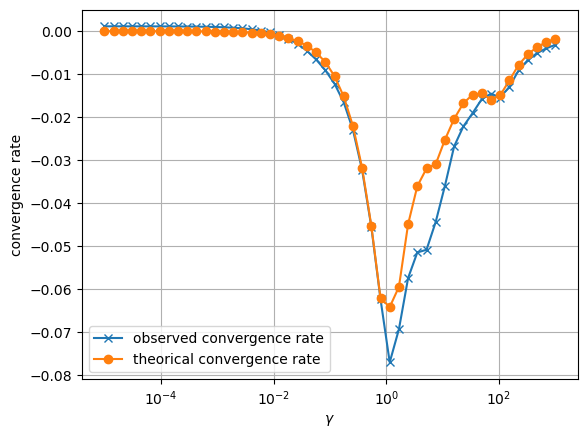

In [44]:
plt.semilogx(gamma_list,conv_factor_obs,'x-',label='observed convergence rate')
plt.semilogx(gamma_list,conv_factor_the,'o-',label='theorical convergence rate')
plt.ylabel(r'convergence rate')
plt.xlabel(r'$\gamma$')
plt.legend()
plt.title('')
plt.grid()